# Experiment Motivation

We test GIN's capability of being highly expressive on the code2 dataset to see if the higher expressiveness improves the performance.



# Setup

In [ ]:
!pip install ogb
!pip install torch_geometric
!python -c "import ogb; print(ogb.__version__)"

import os
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models.tgn import Linear
from torch_geometric.nn import MessagePassing
import torch
import pandas as pd
import torch.nn.functional as F
from tqdm.notebook import tqdm
print(torch.__version__)

# The PyG built-in conv
from torch_geometric.nn import GINConv

import torch_geometric.transforms as T
from torch_geometric.nn import global_add_pool, global_mean_pool
from numpy import float32

import copy
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

2.1.1+cu121
Device: cuda


# Dataset

In [ ]:
dataset = PygGraphPropPredDataset(name = "ogbg-code2")
print(dataset)
evaluator = Evaluator(name='ogbg-code2')
'''
==== Expected input format of Evaluator for ogbg-code2
{'seq_ref': seq_ref, 'seq_pred': seq_pred}
- seq_ref: a list of lists of strings
- seq_pred: a list of lists of strings
where seq_ref stores the reference sequences of sub-tokens, and
seq_pred stores the predicted sequences of sub-tokens.

==== Expected output format of Evaluator for ogbg-code2
{'F1': F1}
- F1 (float): F1 score averaged over samples.
'''
# print(dataset.num_classes)
# print(dataset.num_node_features)
# print(dataset[0])
# print(len(dataset.y))

PygGraphPropPredDataset(452741)


"\n==== Expected input format of Evaluator for ogbg-code2\n{'seq_ref': seq_ref, 'seq_pred': seq_pred}\n- seq_ref: a list of lists of strings\n- seq_pred: a list of lists of strings\nwhere seq_ref stores the reference sequences of sub-tokens, and\nseq_pred stores the predicted sequences of sub-tokens.\n\n==== Expected output format of Evaluator for ogbg-code2\n{'F1': F1}\n- F1 (float): F1 score averaged over samples.\n"

# GNN Model
This model uses multiple GIN layers and a global_add_pool pooling method for graph level aggregation.

In [ ]:
class GNN(torch.nn.Module):
    """
    AST is a directed graph with 100-150 nodes. This GNN takes in nodes of 2 dimension
    features and convert them to 1x256 embeddings using a basic encoder ASTNodeEncoder
    before passing the embedding through conv layers. No self-loops are added to establish
    a baseline.

    Input
        Batch of node_size x256 dimensions
    Output
        Embeddings of batch_size x pred_list_len X num_classes, i.e. 64 x 5 x len(vocab_list)
    """
    def __init__(self, AST_emb, hidden_dim, output_dim, num_layers,
                 dropout, pred_list_len, num_classes):
        super(GNN, self).__init__()

        self.AST_emb = AST_emb
        self.hidden_dim = hidden_dim
        self.pred_list_len = pred_list_len
        self.num_classes = num_classes

        # Probability of an element getting zeroed
        self.dropout = dropout

        # GIN layers, includes a sequential containing batchnorm, ReLu, and dropout
        self.convs = torch.nn.ModuleList()
        self.convs.extend([GINConv(nn=torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.BatchNorm1d(hidden_dim), torch.nn.ReLU(), torch.nn.Dropout(self.dropout))) for i in range(num_layers-1)])
        self.convs.append(GINConv(nn=torch.nn.Sequential(torch.nn.Linear(hidden_dim, output_dim))))

        # Batch norm
        # self.bns = torch.nn.ModuleList()
        # self.bns.extend([torch.nn.BatchNorm1d(hidden_dim) for i in range(num_layers-1)])

        # Global pool
        self.pool_method = global_add_pool

        # Post-processing layer that transform graph embedding into 5 token
        # predictions for each graph
        self.post_mps = Linear(output_dim, num_classes*pred_list_len, bias=True)

        # self.post_mps = torch.nn.ModuleList()
        # for i in range(pred_list_len):
        #     self.post_mps.append(torch.nn.Linear(output_dim, self.num_classes))

        self.softmax = torch.nn.Softmax(dim=-1)

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        # for bn in self.bns:
        #     bn.reset_parameters()

    def forward(self, batched_data):
        x, edge_index, edge_attr, node_depth, batch = batched_data.x, batched_data.edge_index, batched_data.edge_attr, batched_data.node_depth, batched_data.batch

        # Pre-processing. Each node x has two features initially, the node type (e.g for , while)
        # and the node text (e.g. delete). ASTNodeEncoder is used to turn
        # 2 dimension into dim_hidden dimensions through a linear transformation

        # print("Raw x shape {}".format(x.shape)) # batch size * N x D

        x = self.AST_emb(x, node_depth.view(-1,))

        out = None
        for i in range(len(self.convs)-1):
            x = self.convs[i](x, edge_index)
        out = self.convs[-1](x, edge_index) # batch * N x outdim

        out = self.pool_method(out, batch) # batch x outdim
        #print("Output before pooling {}".format(out.shape))

        # We want to turn one single graph embedding per graph to pred 5
        # words. So the desired output is batch_size x word len x num_classes
        out = self.post_mps(out).view(out.shape[0], self.pred_list_len, self.num_classes) # batch_size x word_len x num_classes

        # pred_list = []
        # for i in range(self.pred_list_len):
        #     pred_list.append(self.post_mps[i](out))
        # out = torch.stack(pred_list, dim=1)

        #out = self.softmax(out)
        #print(out)

        return out

# Train

In [ ]:
def train(model, device, data_loader, optimizer, epoch, args):
    model.train()

    loss_accum = 0

    # Used to shorten training for debugging
    max_steps = args['max_steps']

    loss_fn = torch.nn.CrossEntropyLoss()

    for step, batch in enumerate(tqdm(data_loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1 or batch.batch[-1] == 0:
            pass
        else:
            # if epoch < args['warmup']:
            #     iteration = epoch * len(data_loader) + step
            #     for param_group in optimizer.param_groups:
            #         param_group["lr"] = lr_modifier(iteration)

            # Each prediction is the one-hot probability of the classification
            pred_list = model(batch) # batch_size x words per graph x num_classes
            optimizer.zero_grad()

            # y comes in as a list of words per graph. Need to one-hot encode it
            y = one_hot_y(batch.y, args['num_classes'], args['words_per_method_name']) #batch_size x words_per_method_name x num_classes i.e. 32x5x15002

            # print("Pred_list {}".format(pred_list.shape))
            # print("One-hot encoded y shape {}".format(y.shape))

            #print("Batch y {}".format(batch.y[0]))

            # print("Pred_list {}".format(pred_list[0]))
            # print("One-hot encoded y {}".format(y[0]))

            loss = 0
            for i in range(pred_list.shape[0]):
                loss += loss_fn(pred_list[i].to(torch.float32), y[i].to(torch.float32))


            # pred_flat = pred_list.view(pred_list.shape[0]*args['words_per_method_name'],
            #                            args['num_classes']) # batch*word len x num_class
            # y_flat = y.view(y.shape[0]*args['words_per_method_name'],
            #                            args['num_classes']) # batch*word len x num_class

            #loss = loss_fn(pred_flat, y_flat.to(torch.float32))

            # print("Pred flat {}".format(pred_flat))
            # print("Y_flat {}".format(y_flat))

            loss_accum += loss/pred_list.shape[0]

            #print("Loss {}".format(loss.item()))

            loss.backward()
            optimizer.step()

            # Used to shorten training for debugging
            if step > max_steps:
                break

    print("Epoch loss {}".format(loss_accum / (step+1)))


# Eval

In [ ]:
def eval(model, device, loader, evaluator, args):
    model.eval()
    seq_ref_list = []
    seq_pred_list = []

    # Used to shorten training for debugging
    max_steps = args['max_steps']

    for step, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device)

        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred_list = model(batch) # batch_size x pred_list_len X num_classes

            #print("Preds are {}".format(pred_list.shape))
            seq_ref_list.extend(batch.y)
            seq_pred_list.extend(decode_to_word(pred_list))

            #print("Seq_ref_list len {} pred list len {}".format(len(seq_ref_list), len(seq_pred_list)))

        # Used to shorten for debugging
        if step > max_steps:
            break

    print("seq_ref_list {}".format(seq_ref_list[:5]))
    print("seq_pred_list {}".format(seq_pred_list[:5]))

    input_dict = {"seq_ref": seq_ref_list, "seq_pred": seq_pred_list}

    return evaluator.eval(input_dict)

# Helper methods
Might modularize away in a different file

In [ ]:
class ASTNodeEncoder(torch.nn.Module):
    '''
        Input:
            x: default node feature. the first and second column represents node type and node attributes.
            depth: The depth of the node in the AST.

        Output:
            emb_dim-dimensional vector

    '''
    def __init__(self, emb_dim, num_nodetypes, num_nodeattributes, max_depth):
        super(ASTNodeEncoder, self).__init__()

        self.max_depth = max_depth

        self.type_encoder = torch.nn.Embedding(num_nodetypes, emb_dim)
        self.attribute_encoder = torch.nn.Embedding(num_nodeattributes, emb_dim)
        self.depth_encoder = torch.nn.Embedding(self.max_depth + 1, emb_dim)


    def forward(self, x, depth):
        depth[depth > self.max_depth] = self.max_depth
        return self.type_encoder(x[:,0]) + self.attribute_encoder(x[:,1]) + self.depth_encoder(depth)


def get_vocab_mapping(seq_list, num_vocab):
    '''
        Input:
            seq_list: a list of sequences
            num_vocab: vocabulary size
        Output:
            vocab2idx:
                A dictionary that maps vocabulary into integer index.
                Additioanlly, we also index '__UNK__' and '__EOS__'
                '__UNK__' : out-of-vocabulary term
                '__EOS__' : end-of-sentence
            idx2vocab:
                A list that maps idx to actual vocabulary.
    '''

    vocab_cnt = {}
    vocab_list = []
    for seq in seq_list:
        for w in seq:
            if w in vocab_cnt:
                vocab_cnt[w] += 1
            else:
                vocab_cnt[w] = 1
                vocab_list.append(w)

    cnt_list = np.array([vocab_cnt[w] for w in vocab_list])
    topvocab = np.argsort(-cnt_list, kind = 'stable')[:num_vocab]

    print('Coverage of top {} vocabulary:'.format(num_vocab))
    print(float(np.sum(cnt_list[topvocab]))/np.sum(cnt_list))

    vocab2idx = {vocab_list[vocab_idx]: idx for idx, vocab_idx in enumerate(topvocab)}
    idx2vocab = [vocab_list[vocab_idx] for vocab_idx in topvocab]

    # print(topvocab)
    # print([vocab_list[v] for v in topvocab[:10]])
    # print([vocab_list[v] for v in topvocab[-10:]])

    vocab2idx['__UNK__'] = num_vocab
    idx2vocab.append('__UNK__')

    vocab2idx['__EOS__'] = num_vocab + 1
    idx2vocab.append('__EOS__')

    # test the correspondence between vocab2idx and idx2vocab
    for idx, vocab in enumerate(idx2vocab):
        assert(idx == vocab2idx[vocab])

    # test that the idx of '__EOS__' is len(idx2vocab) - 1.
    # This fact will be used in decode_arr_to_seq, when finding __EOS__
    assert(vocab2idx['__EOS__'] == len(idx2vocab) - 1)

    return vocab2idx, idx2vocab

def one_hot_y(batch_y, num_classes, max_seq_len):
    '''
    Given data.y, produce a tensor batch_size x number of words per method name.

    Input:
        batch_data.y: a list of lists, each of word len. batch_size x word len
        output: one hot encoding of dimensions batch_size x word len x num_classes.
    '''
    #print(batch_y)
    labels = torch.zeros(len(batch_y), max_seq_len, dtype=torch.long).to(device)

    for i, y in enumerate(batch_y):
        # if the number of words in y is less than the max length, fill blanks with end of word token
        y = y[:max_seq_len] + ['__EOS__'] * max(0, max_seq_len - len(y))
        for j, w in enumerate(y):
            index = vocab2idx['__UNK__']
            if w in vocab2idx:
                index = vocab2idx[w]
            labels[i][j] = index
        # print(labels[i])
    labels_one_hot = F.one_hot(labels, num_classes).to(device) # batch x word len x num_class
    #print('labels {}'.format(labels_one_hot))

    return labels_one_hot

def decode_to_word(pred_list):
    '''
        The goal is to turn an one-hot-encoder back into word. We need to take the
        argmax of the prediction

        Input:  embeddings, batch x word len x num class
        Output: list of lists, each a sequence of words. batch x word len
    '''
    #print("Prediction {}".format(pred_list))
    argmax = torch.argmax(pred_list, dim=-1).tolist()
    #print("Argmax {}".format(argmax))

    for i, graph in enumerate(argmax):
        word_list = []
        for word_index in graph:
            if word_index < len(vocab2idx) - 2:
                w = idx2vocab[word_index]
                word_list.append(w)
        argmax[i] = word_list
    #print("decoded pred words {}".format(argmax))
    return argmax

#Run Epochs
Train and then evaluate the accuracy of the GCN model

In [ ]:
def run_epochs(model, evaluator, args, dataset):
    split_idx = dataset.get_idx_split()
    train_loader = DataLoader(dataset[split_idx["train"]], batch_size=args['batch_size'], shuffle=True)
    valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args['batch_size'], shuffle=False)
    test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args['batch_size'], shuffle=False)

    valid_curve = []
    test_curve = []
    train_curve = []

    optimizer = torch.optim.AdamW(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

    # # We want to decrease lr as training goes progresses.
    # # lr_scheduler method decays lr with a cosine annealing according to https://arxiv.org/pdf/1608.03983.pdf
    # lr_modifier = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args['epochs'])
    # lr_steps = args['lr'] / (args['warmup'] * len(train_loader))
    # def lr_scheduler(s):
    #     lr = s * lr_steps
    #     return lr

    for epoch in range(1, args['epochs'] + 1):
        print("=====Epoch {}".format(epoch))
        print('Training...')
        train(model, device, train_loader, optimizer, epoch, args)

        print('Evaluating...')
        train_perf = eval(model, device, train_loader, evaluator, args)
        valid_perf = eval(model, device, valid_loader, evaluator, args)
        test_perf = eval(model, device, test_loader, evaluator, args)

        # if epoch >= args['warmup'] and lr_modifier is not None:
        #     lr_modifier.step()

        print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

        train_curve.append(train_perf[dataset.eval_metric])
        valid_curve.append(valid_perf[dataset.eval_metric])
        test_curve.append(test_perf[dataset.eval_metric])

    print('F1')
    best_val_epoch = np.argmax(np.array(valid_curve))
    best_train = max(train_curve)
    print('Finished training!')
    print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
    print('Test score: {}'.format(test_curve[best_val_epoch]))

    return valid_curve, test_curve, train_curve

# 5-layers

Grab ogbg-code2 and create a dictionary of all of the y labels

In [ ]:
args = {
    'device': device,
    'num_layers': 5,
    'hidden_dim': 256,
    'output_dim': 256,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 25,
    'num_vocab': 5000,
    'warmup': 2,
    'weight_decay': 0.000001,
    'words_per_method_name': 5,
    'max_steps': 99999,
    'batch_size': 32,
}

# There are 450k words (duplicates included) in the true labels.
# The top 15k is extracted and stored in a dict vocab2idx.
# This top 15k covers 96% of the all unique words.
vocab2idx, idx2vocab = get_vocab_mapping(dataset.y, args['num_vocab'])
print("Vocab list {}".format(vocab2idx))
args['num_classes'] = len(vocab2idx)

Coverage of top 5000 vocabulary:
0.901200162173439
Vocab list {'get': 0, 'to': 1, 'set': 2, 'create': 3, 'from': 4, 'add': 5, 'parse': 6, 'update': 7, 'list': 8, 'file': 9, 'check': 10, 'data': 11, 'is': 12, 'load': 13, 'read': 14, 'run': 15, 'by': 16, 'delete': 17, 'find': 18, 'write': 19, 'for': 20, 'name': 21, 'make': 22, 'remove': 23, 'dict': 24, 'all': 25, 'build': 26, 'config': 27, 'process': 28, 'path': 29, 'validate': 30, 'send': 31, 'on': 32, 'request': 33, 'save': 34, 'value': 35, 'type': 36, 'id': 37, 'generate': 38, 'info': 39, 'and': 40, 'user': 41, 'handle': 42, 'url': 43, 'init': 44, 'key': 45, 'string': 46, 'start': 47, 'with': 48, 'filter': 49, 'json': 50, 'convert': 51, 'query': 52, 'format': 53, 'main': 54, 'register': 55, 'plot': 56, 'in': 57, 'output': 58, 'event': 59, 'search': 60, 'model': 61, 'state': 62, 'message': 63, 'log': 64, 'index': 65, 'group': 66, 'table': 67, 'do': 68, 'extract': 69, 'as': 70, 'default': 71, 'text': 72, 'image': 73, 'object': 74, 'map'

In [ ]:
def main():
    nodetypes_mapping = pd.read_csv(os.path.join(dataset.root, 'mapping', 'typeidx2type.csv.gz'))
    nodeattributes_mapping = pd.read_csv(os.path.join(dataset.root, 'mapping', 'attridx2attr.csv.gz'))

    node_encoder = ASTNodeEncoder(args['hidden_dim'], num_nodetypes = len(nodetypes_mapping['type']), num_nodeattributes = len(nodeattributes_mapping['attr']), max_depth = 20)

    print(node_encoder)

    gnn = GNN(
        node_encoder,
        args['hidden_dim'],
        args['output_dim'],
        args['num_layers'],
        args['dropout'],
        args['words_per_method_name'],
        args['num_classes'],
    ).to(device)

    # param_size = 0
    # for param in gcn.parameters():
    #     param_size += param.nelement() * param.element_size()
    # print(param_size)

    return run_epochs(gnn, evaluator, args, dataset)


valid_curve = []
test_curve = []
train_curve = []

valid_curve, test_curve, train_curve = main()

ASTNodeEncoder(
  (type_encoder): Embedding(98, 256)
  (attribute_encoder): Embedding(10030, 256)
  (depth_encoder): Embedding(21, 256)
)
=====Epoch 1
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 3.7832038402557373
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['read', 'buttoncondaction', 'ss'], ['make', 'order'], ['deploy', 'api', 'gateway'], ['add', 'method', 'model'], ['update', 'todo', 'item']]
seq_pred_list [['get'], ['get'], [], ['get'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [[], ['get'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['get'], ['get'], ['get'], ['get'], ['get']]
{'Train': {'precision': 0.10087501062153982, 'recall': 0.04098856703182692, 'F1': 0.056126910218327365}, 'Validation': {'precision': 0.09354866985142657, 'recall': 0.038741285911159246, 'F1': 0.05276850802555321}, 'Test': {'precision': 0.09178512848551121, 'recall': 0.03830565608176324, 'F1': 0.05228476872134608}}
=====Epoch 2
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 3.1820473670959473
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['next', 'sample', 'index'], ['publish'], ['execute', 'insert', 'no', 'results'], ['get', 'last', 'documents'], ['expose', 'all', 'eligible', 'locations']]
seq_pred_list [['get'], ['get'], ['set'], ['get'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['assert', 'heatmap', 'area'], ['write'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['get'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.10695706773601066, 'recall': 0.04410905178229725, 'F1': 0.059825081036006526}, 'Validation': {'precision': 0.09426085813209449, 'recall': 0.03879008689566607, 'F1': 0.05280683923362628}, 'Test': {'precision': 0.09172817568798979, 'recall': 0.03845677083785339, 'F1': 0.0522303109987637}}
=====Epoch 3
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 3.117154121398926
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['all'], ['preprocess', 'data'], ['get', 'payload', 'struct'], ['handle', 'struct', 'ref'], ['parent', 'foreign', 'key', 'mappings']]
seq_pred_list [['get'], [], ['get'], ['get'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['extended'], ['write'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['get'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.12519964409671158, 'recall': 0.05515986475951034, 'F1': 0.07310627205960639}, 'Validation': {'precision': 0.11356809980862223, 'recall': 0.04757029880950642, 'F1': 0.06431441051680348}, 'Test': {'precision': 0.10717149626389648, 'recall': 0.04515214171447085, 'F1': 0.06124957297729303}}
=====Epoch 4
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 3.0577213764190674
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['countthai'], ['set'], ['current', 'above'], ['save', 'to', 'cache'], ['set']]
seq_pred_list [[], ['set'], [], ['get'], ['set']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['stats'], ['write'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['get'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.1394493793752574, 'recall': 0.06160069167084286, 'F1': 0.0815698648714089}, 'Validation': {'precision': 0.12121079312208732, 'recall': 0.051126753165803, 'F1': 0.06895172146081556}, 'Test': {'precision': 0.11870026122349796, 'recall': 0.05247518666053384, 'F1': 0.06970415248846086}}
=====Epoch 5
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 3.0224170684814453
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['beacon'], ['set', 'attachments', 'order'], ['add', 'group', 'memberships'], ['set', 'up'], ['prep', 'priority', 'filter', 'vcfanno']]
seq_pred_list [['p'], ['set'], ['set'], ['set'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['plot', 'trees'], ['write'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['get'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.1319313717800393, 'recall': 0.05882754299922219, 'F1': 0.07759495398865793}, 'Validation': {'precision': 0.11510204379775314, 'recall': 0.04847229961508788, 'F1': 0.06540792822950862}, 'Test': {'precision': 0.10954832634712351, 'recall': 0.04785593509623034, 'F1': 0.06384434243236867}}
=====Epoch 6
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.985412359237671
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['message'], ['get', 'enabled', 'heuristics'], ['fit'], ['showtraceback'], ['copy']]
seq_pred_list [[], ['get'], ['add'], ['send'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['summary', 'func'], ['load', 'file'], [], [], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['get'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.14398420495323255, 'recall': 0.06687523867652109, 'F1': 0.08652281682825033}, 'Validation': {'precision': 0.12394705701888944, 'recall': 0.0541095959501096, 'F1': 0.07176489125693666}, 'Test': {'precision': 0.11870102059413158, 'recall': 0.05400119618955048, 'F1': 0.0707791681821206}}
=====Epoch 7
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.973397970199585
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['is', 'one', 'of'], ['get'], ['package', 'split'], ['remove', 'hop', 'by', 'hop', 'headers'], ['full', 'report']]
seq_pred_list [['get'], ['get'], ['mkdir', 'path'], ['get'], ['display', 'packet']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['display', 'shapes', 'inference'], ['write'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.14241046041924027, 'recall': 0.06726495867566662, 'F1': 0.08682026214972687}, 'Validation': {'precision': 0.1226943360944325, 'recall': 0.052903102045189075, 'F1': 0.07076424814514834}, 'Test': {'precision': 0.12052275074418321, 'recall': 0.05532293501812364, 'F1': 0.07236361308941953}}
=====Epoch 8
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.956638813018799
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['cyvcf', 'remove', 'filter'], ['get', 'section', 'data'], ['map'], ['init'], ['set', 'away']]
seq_pred_list [['get'], ['get'], ['get'], ['on'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['classify', 'model', 'fn'], ['load', 'file'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['get'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.15405938911439238, 'recall': 0.07468643950091387, 'F1': 0.09506683922100044}, 'Validation': {'precision': 0.130617522023053, 'recall': 0.05851671094582082, 'F1': 0.07687549870571302}, 'Test': {'precision': 0.12826225624202658, 'recall': 0.0604751562857085, 'F1': 0.07815873199962865}}
=====Epoch 9
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.9146535396575928
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['smooth', 'gaussian'], ['compute', 'limb', 'angle'], ['delete', 'layer', 'node'], ['import', 'basemap'], ['do', 'get']]
seq_pred_list [[], [], [], [], ['do']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [[], ['load'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.15901082416612744, 'recall': 0.07827154891982235, 'F1': 0.0989914572209598}, 'Validation': {'precision': 0.13513170004820962, 'recall': 0.06129565396449737, 'F1': 0.07979531413155465}, 'Test': {'precision': 0.131612599477553, 'recall': 0.06229384895322566, 'F1': 0.08022819777877187}}
=====Epoch 10
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.900426149368286
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['get', 'type', 'data'], ['stsci2'], ['find', 'matches'], ['fetch'], ['get', 'circles']]
seq_pred_list [['get', 'name'], ['get'], [], ['get'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['run', 'and', 'artists'], ['write', 'file'], [], ['get'], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.16844557032766633, 'recall': 0.08539979679293024, 'F1': 0.10680563228882864}, 'Validation': {'precision': 0.1422901053308206, 'recall': 0.06770941813782677, 'F1': 0.08636219759943299}, 'Test': {'precision': 0.14051546078610047, 'recall': 0.06874372615214605, 'F1': 0.08747414852526934}}
=====Epoch 11
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.888972282409668
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['extract', 'signature'], ['send'], ['init', 'request', 'logging'], ['sort', 'dependencies'], ['setup', 'logger']]
seq_pred_list [['get'], ['send'], ['set'], ['get'], ['get', 'logger']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['a', 'diff', 'descriptors', 'new', 'to'], ['load', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['get'], ['generate']]
{'Train': {'precision': 0.16817182056460836, 'recall': 0.08526311555405174, 'F1': 0.10660236066360108}, 'Validation': {'precision': 0.14136535624023025, 'recall': 0.06534825746049834, 'F1': 0.08448153041000478}, 'Test': {'precision': 0.13921314014944414, 'recall': 0.0675537923692653, 'F1': 0.08610435238374001}}
=====Epoch 12
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.865097761154175
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['paginate', 'data'], ['json', 'dump', 'hook'], ['execute', 'on', 'member'], ['wnfltd'], ['recruit']]
seq_pred_list [['get'], ['write'], ['get'], [], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [[], ['download', 'file'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.16222870136151799, 'recall': 0.08084003216511013, 'F1': 0.10207750989125487}, 'Validation': {'precision': 0.1316671779813297, 'recall': 0.06070527683688923, 'F1': 0.0788177291924498}, 'Test': {'precision': 0.13172574570196222, 'recall': 0.06337747084739975, 'F1': 0.08123136254628872}}
=====Epoch 13
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.8536200523376465
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['get', 'has', 'relation', 'query'], ['p', 'next'], ['abort'], ['parse', 'group'], ['from', 'raw', 'message']]
seq_pred_list [['get'], ['get'], ['get'], ['write'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['cluster'], ['load', 'file'], [], [], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['get'], ['get']]
{'Train': {'precision': 0.17447398866599995, 'recall': 0.09019988441112478, 'F1': 0.11194059939469944}, 'Validation': {'precision': 0.1427203400972959, 'recall': 0.06715330257097361, 'F1': 0.08619596499685907}, 'Test': {'precision': 0.1412611627483142, 'recall': 0.07042106740029101, 'F1': 0.08877954280496653}}
=====Epoch 14
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.8436615467071533
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['load', 'project', 'metrics'], ['add', 'field', 'processors'], ['get', 'urls'], ['tagged'], ['send']]
seq_pred_list [['get'], ['add'], ['get'], ['get'], ['set']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [[], ['write', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], ['get'], []]
{'Train': {'precision': 0.17260798837840136, 'recall': 0.089129156593603, 'F1': 0.1107121635582612}, 'Validation': {'precision': 0.14357642693313466, 'recall': 0.06726123518317934, 'F1': 0.08656717248556665}, 'Test': {'precision': 0.1391880809185347, 'recall': 0.06818211732782536, 'F1': 0.08667619463136139}}
=====Epoch 15
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.835416078567505
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['scalars', 'route'], ['check', 'state'], ['get'], ['render'], ['vcf', 'as', 'df']]
seq_pred_list [[], ['get'], ['get'], [], ['read']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['statistics', 'interaction'], ['read'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.16857948343366602, 'recall': 0.08654021019913868, 'F1': 0.10792373685549525}, 'Validation': {'precision': 0.14083431944018351, 'recall': 0.06574635244815373, 'F1': 0.08472264831777475}, 'Test': {'precision': 0.13769439888220644, 'recall': 0.06846568801872246, 'F1': 0.08657534297911554}}
=====Epoch 16
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.825836420059204
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['bool', 'prop'], ['by', 'pattern'], ['run', 'config'], ['add', 'child', 'tn', 'lst'], ['make', 'request']]
seq_pred_list [['get'], ['get'], ['load'], ['get'], ['set']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train', 'state'], ['write', 'file'], [], ['get'], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['get'], ['get']]
{'Train': {'precision': 0.18828570798282251, 'recall': 0.10034890266006803, 'F1': 0.1229591694813174}, 'Validation': {'precision': 0.15647616543220697, 'recall': 0.07618367605329081, 'F1': 0.09640789591265113}, 'Test': {'precision': 0.150555859303809, 'recall': 0.07647672275884412, 'F1': 0.09566840855113133}}
=====Epoch 17
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.8136188983917236
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['restore'], ['get', 'feed', 'renderer'], ['basis'], ['store'], ['reparent', 'unions']]
seq_pred_list [['create'], ['get'], [], ['create'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['run', 'lc', 'scoring'], ['save', 'file', 'file'], [], ['get'], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['get'], ['get']]
{'Train': {'precision': 0.18728883561778142, 'recall': 0.10034373062804883, 'F1': 0.12278018531329883}, 'Validation': {'precision': 0.155646374779039, 'recall': 0.07601421176496777, 'F1': 0.09592012955075584}, 'Test': {'precision': 0.15443776198286857, 'recall': 0.07898253736826727, 'F1': 0.09853506885354889}}
=====Epoch 18
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.8166286945343018
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['close'], ['delete', 'enrollment', 'claim'], ['authorization', 'code', 'flow'], ['max', 'interval', 'intersec'], ['system', 'monitor', 'mail', 'sfp', 'email', 'list', 'email']]
seq_pred_list [['set'], ['get'], ['get'], [], ['snmp', 'sa', 'hidden', 'threshold', 'monitor']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['call', 'fit'], ['write', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], [], ['create']]
{'Train': {'precision': 0.18186261773568374, 'recall': 0.09697277351330531, 'F1': 0.11908665373958567}, 'Validation': {'precision': 0.14757271624958002, 'recall': 0.07174946485876933, 'F1': 0.09085548034138997}, 'Test': {'precision': 0.14650309823218516, 'recall': 0.07515151252166015, 'F1': 0.09387962062237622}}
=====Epoch 19
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.794013261795044
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['get', 'server', 'certificate'], ['list', 'files'], ['create'], ['next', 'index'], ['anlzd', 'stdev']]
seq_pred_list [['get'], ['get', 'path'], ['get'], ['get'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train', 'step', 'neighbor', 'detail'], ['write', 'file'], [], ['get'], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], ['get'], ['get']]
{'Train': {'precision': 0.1866806299063344, 'recall': 0.10083689854558729, 'F1': 0.12275108139023748}, 'Validation': {'precision': 0.15364129085038933, 'recall': 0.07533976337609592, 'F1': 0.09472159786180033}, 'Test': {'precision': 0.15146254784034993, 'recall': 0.07712023513007657, 'F1': 0.0962493994068625}}
=====Epoch 20
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.7916605472564697
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['parse'], ['update'], ['list', 'cmd'], ['dynamic', 'filter'], ['stream', 'restore', 'write']]
seq_pred_list [['mouse'], ['get'], ['main'], ['get'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['sample'], ['write', 'file', 'file'], [], ['get'], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], ['get'], ['get']]
{'Train': {'precision': 0.1882171581988483, 'recall': 0.10513697034724004, 'F1': 0.1266591957181524}, 'Validation': {'precision': 0.1548742896378431, 'recall': 0.07826003098497292, 'F1': 0.09735807160315203}, 'Test': {'precision': 0.15120967741935484, 'recall': 0.0803372545786433, 'F1': 0.09852693273961728}}
=====Epoch 21
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.7857017517089844
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['delete', 'image'], ['ts', 'merge'], ['show'], ['from', 'binary'], ['shrink', 'wrap']]
seq_pred_list [['get'], [], ['write'], ['from'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['produce', 'market'], ['write'], [], ['get'], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], ['add'], []]
{'Train': {'precision': 0.19038064330581536, 'recall': 0.10104218567712743, 'F1': 0.1242072305977842}, 'Validation': {'precision': 0.15542212677681844, 'recall': 0.0743937616828444, 'F1': 0.09490814075553523}, 'Test': {'precision': 0.15371484113966347, 'recall': 0.07788568072876438, 'F1': 0.0977299551793811}}
=====Epoch 22
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.7792861461639404
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['start', 'dashboard'], ['render', 'edge', 'with', 'node', 'label'], ['minor', 'residues', 'per', 'turn'], ['syndic', 'cmd'], ['get', 'runlevels', 'lsb']]
seq_pred_list [['start', 'process', 'ssh'], ['add'], ['get'], ['write'], ['is']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['run', 'cb'], ['write'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['add'], ['get']]
{'Train': {'precision': 0.19314359177990864, 'recall': 0.10540107760550876, 'F1': 0.12791129667631307}, 'Validation': {'precision': 0.1544411330732933, 'recall': 0.07621216358451753, 'F1': 0.09575368824831944}, 'Test': {'precision': 0.1526334973573902, 'recall': 0.0800874216401827, 'F1': 0.09872144010334277}}
=====Epoch 23
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.769239664077759
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['get', 'preferred'], ['before', 'submission', 'insertion'], ['cache', 'add'], ['env', 'bool'], ['action', 'draft']]
seq_pred_list [['get'], ['get', 'view'], ['get'], ['is'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['solve', 'actor'], ['write', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.18707681334196133, 'recall': 0.0988823079935057, 'F1': 0.12191105532417086}, 'Validation': {'precision': 0.150273188119969, 'recall': 0.07255949859162375, 'F1': 0.09230972311789248}, 'Test': {'precision': 0.14864452341899034, 'recall': 0.07510497394997122, 'F1': 0.09445536820468477}}
=====Epoch 24
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.770467519760132
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['merge', 'batches'], ['format', 'size'], ['add', 'metadata', 'defaults'], ['plot', 'line', 'ids'], ['scroll']]
seq_pred_list [[], ['unit'], ['get'], ['plot', 'trajectory'], ['close']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['fit', 'world'], ['write', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], ['add'], ['get']]
{'Train': {'precision': 0.188815477707839, 'recall': 0.10536359264225612, 'F1': 0.12675322076037934}, 'Validation': {'precision': 0.150666169960994, 'recall': 0.07563396061555329, 'F1': 0.09418635228119383}, 'Test': {'precision': 0.15236999574752444, 'recall': 0.08052492760666626, 'F1': 0.09895872534609548}}
=====Epoch 25
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.763248920440674
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['instruction', 'bvc'], ['goals', 'by', 'version'], ['pickle', 'encode'], ['project'], ['translate']]
seq_pred_list [['instruction'], ['get'], ['get'], ['project', 'decomposition'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['model', 'optimizer', 'grad'], ['write', 'file'], [], ['get'], ['get']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'url', 'url'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.1886838931701865, 'recall': 0.10327416468384318, 'F1': 0.12521621727509955}, 'Validation': {'precision': 0.15270996771413128, 'recall': 0.07571942320923343, 'F1': 0.09464994424235341}, 'Test': {'precision': 0.15034627300893022, 'recall': 0.07891365160364613, 'F1': 0.09731526649241246}}
F1
Finished training!
Best validation score: 0.09735807160315203
Test score: 0.09852693273961728


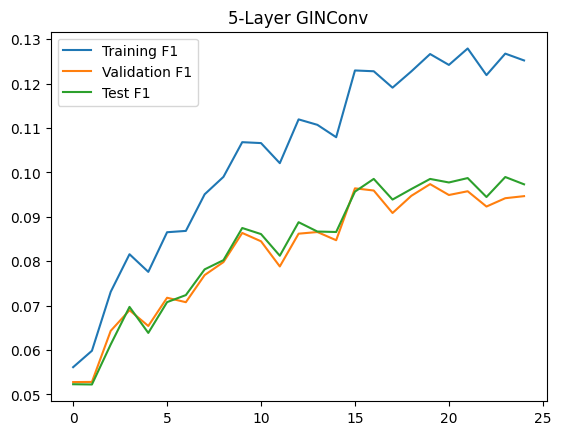

In [ ]:
from matplotlib import pyplot as plt

plt.title("5-Layer GINConv")
plt.plot(train_curve, label="Training F1")
plt.plot(valid_curve, label="Validation F1")
plt.plot(test_curve, label="Test F1")
plt.legend()
plt.show()

# 3-Layers

In [ ]:
args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 256,
    'output_dim': 256,
    'dropout': 0.5,
    'lr': 0.001,
    'epochs': 25,
    'num_vocab': 5000,
    'warmup': 2,
    'weight_decay': 0.000001,
    'words_per_method_name': 5,
    'max_steps': 99999,
    'batch_size': 32,
}

# There are 450k words (duplicates included) in the true labels.
# The top 15k is extracted and stored in a dict vocab2idx.
# This top 15k covers 96% of the all unique words.
vocab2idx, idx2vocab = get_vocab_mapping(dataset.y, args['num_vocab'])
print("Vocab list {}".format(vocab2idx))
args['num_classes'] = len(vocab2idx)

Coverage of top 5000 vocabulary:
0.901200162173439
Vocab list {'get': 0, 'to': 1, 'set': 2, 'create': 3, 'from': 4, 'add': 5, 'parse': 6, 'update': 7, 'list': 8, 'file': 9, 'check': 10, 'data': 11, 'is': 12, 'load': 13, 'read': 14, 'run': 15, 'by': 16, 'delete': 17, 'find': 18, 'write': 19, 'for': 20, 'name': 21, 'make': 22, 'remove': 23, 'dict': 24, 'all': 25, 'build': 26, 'config': 27, 'process': 28, 'path': 29, 'validate': 30, 'send': 31, 'on': 32, 'request': 33, 'save': 34, 'value': 35, 'type': 36, 'id': 37, 'generate': 38, 'info': 39, 'and': 40, 'user': 41, 'handle': 42, 'url': 43, 'init': 44, 'key': 45, 'string': 46, 'start': 47, 'with': 48, 'filter': 49, 'json': 50, 'convert': 51, 'query': 52, 'format': 53, 'main': 54, 'register': 55, 'plot': 56, 'in': 57, 'output': 58, 'event': 59, 'search': 60, 'model': 61, 'state': 62, 'message': 63, 'log': 64, 'index': 65, 'group': 66, 'table': 67, 'do': 68, 'extract': 69, 'as': 70, 'default': 71, 'text': 72, 'image': 73, 'object': 74, 'map'

In [ ]:
def main():
    nodetypes_mapping = pd.read_csv(os.path.join(dataset.root, 'mapping', 'typeidx2type.csv.gz'))
    nodeattributes_mapping = pd.read_csv(os.path.join(dataset.root, 'mapping', 'attridx2attr.csv.gz'))

    node_encoder = ASTNodeEncoder(args['hidden_dim'], num_nodetypes = len(nodetypes_mapping['type']), num_nodeattributes = len(nodeattributes_mapping['attr']), max_depth = 20)

    print(node_encoder)

    gnn = GNN(
        node_encoder,
        args['hidden_dim'],
        args['output_dim'],
        args['num_layers'],
        args['dropout'],
        args['words_per_method_name'],
        args['num_classes'],
    ).to(device)

    # param_size = 0
    # for param in gcn.parameters():
    #     param_size += param.nelement() * param.element_size()
    # print(param_size)

    return run_epochs(gnn, evaluator, args, dataset)


valid_curve = []
test_curve = []
train_curve = []

valid_curve, test_curve, train_curve = main()

ASTNodeEncoder(
  (type_encoder): Embedding(98, 256)
  (attribute_encoder): Embedding(10030, 256)
  (depth_encoder): Embedding(21, 256)
)
=====Epoch 1
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 3.833549737930298
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['hmset'], ['stop'], ['default'], ['from', 'dict'], ['normalize']]
seq_pred_list [[], [], [], ['set'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['fun', 'simulation'], ['save', 'file'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.1054116336908707, 'recall': 0.04652960317723686, 'F1': 0.061644352015760774}, 'Validation': {'precision': 0.08861448335305547, 'recall': 0.038033532502568745, 'F1': 0.0509580715019642}, 'Test': {'precision': 0.08845301014519168, 'recall': 0.038519635878165134, 'F1': 0.05162928722250756}}
=====Epoch 2
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 3.0531556606292725
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['is', 'on'], ['select', 'warp', 'gates'], ['fetch', 'album'], ['check', 'is', 'reachable'], ['rjust', 'text']]
seq_pred_list [['is'], ['get'], ['get'], [], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['fit', 'transform', 'mean'], ['load'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.14270055101280468, 'recall': 0.06501890010901572, 'F1': 0.08508794054542099}, 'Validation': {'precision': 0.12392806533140496, 'recall': 0.053904478768615156, 'F1': 0.07190319286125045}, 'Test': {'precision': 0.11968820241783609, 'recall': 0.0524671590281213, 'F1': 0.07002952472471334}}
=====Epoch 3
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.9644100666046143
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['split', 'queries'], ['find', 'serial', 'devices'], ['highlight', 'characters'], ['paragraph', 'ends'], ['safe', 'invoke', 'callback']]
seq_pred_list [['get'], ['get'], [], ['get'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['transfer'], ['write'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.1523940133733357, 'recall': 0.07441945508247201, 'F1': 0.0946187931818233}, 'Validation': {'precision': 0.1262808432309243, 'recall': 0.0588094472862409, 'F1': 0.07599764067967602}, 'Test': {'precision': 0.1266964339955045, 'recall': 0.060524406895374624, 'F1': 0.07783466154160523}}
=====Epoch 4
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.8885605335235596
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['real', 'time', 'statistics'], ['solve'], ['get', 'hook', 'status'], ['uint32', 'to', 'uint8'], ['can', 'merge', 'tail']]
seq_pred_list [['get'], ['predict'], ['get'], [], ['is']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [[], ['save'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.16810894921923514, 'recall': 0.08390983010666521, 'F1': 0.1058355573320839}, 'Validation': {'precision': 0.13961446874406508, 'recall': 0.06481520322844773, 'F1': 0.08403856495191903}, 'Test': {'precision': 0.13874233035660047, 'recall': 0.06613203358009263, 'F1': 0.08514718378031665}}
=====Epoch 5
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.8489251136779785
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['user', 'return'], ['check', 'num', 'tasks'], ['set', 'menu'], ['get', 'method'], ['sync']]
seq_pred_list [['set'], ['get'], ['on', 'menu', 'menu'], ['get'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['transformer'], ['write'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['write']]
{'Train': {'precision': 0.1812391741997895, 'recall': 0.09180093299416497, 'F1': 0.11518465191509575}, 'Validation': {'precision': 0.15226001081065288, 'recall': 0.07140184045452048, 'F1': 0.09200961271566521}, 'Test': {'precision': 0.15271247190328657, 'recall': 0.07615160364613617, 'F1': 0.09638901512192928}}
=====Epoch 6
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.815565586090088
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['get', 'connected', 'subgraphs'], ['gen', 'txt', 'repr'], ['iter', 'all', 'children'], ['remove', 'refs'], ['send']]
seq_pred_list [['get'], [], ['get'], ['get'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [[], ['load'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.17600271421194708, 'recall': 0.08896172851497429, 'F1': 0.11167602736125615}, 'Validation': {'precision': 0.14397963506742048, 'recall': 0.06860129700007861, 'F1': 0.08788101084853506}, 'Test': {'precision': 0.14071593463337587, 'recall': 0.06820055918607038, 'F1': 0.08718782963588867}}
=====Epoch 7
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.7829859256744385
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['parse', 'args'], ['update', 'branding'], ['raw'], ['get', 'deserializer'], ['nt', 'db', 'search']]
seq_pred_list [['init'], ['create'], [], ['get'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['pool'], ['write', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['write']]
{'Train': {'precision': 0.18249692792386477, 'recall': 0.09725502586810605, 'F1': 0.11936507011555361}, 'Validation': {'precision': 0.14810229215058945, 'recall': 0.07233006787615193, 'F1': 0.09139662643628983}, 'Test': {'precision': 0.1498800194398882, 'recall': 0.07690207879518979, 'F1': 0.09601605565930334}}
=====Epoch 8
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.7574541568756104
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['response', 'status'], ['get', 'word', 'vectors'], ['interval'], ['kldiv', 'model'], ['market', 'price']]
seq_pred_list [['validate'], [], ['get'], [], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['solve', 'mle'], ['save', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['write']]
{'Train': {'precision': 0.18862159375388096, 'recall': 0.10137975829340024, 'F1': 0.12425403911288128}, 'Validation': {'precision': 0.15357262859563775, 'recall': 0.07579872915697082, 'F1': 0.09560095473230415}, 'Test': {'precision': 0.1558388008018954, 'recall': 0.08094323234427116, 'F1': 0.10070798984139606}}
=====Epoch 9
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.7369678020477295
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['do', 'attr'], ['user', 'create'], ['from', 'text', 'files'], ['load', 'db'], ['get', 'details']]
seq_pred_list [[], ['user'], ['from'], ['load'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['optimize'], ['write'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.19616562412168034, 'recall': 0.10371425327966892, 'F1': 0.1278199626623555}, 'Validation': {'precision': 0.1567062570305766, 'recall': 0.07598134153662925, 'F1': 0.09664365719061778}, 'Test': {'precision': 0.15711985906081039, 'recall': 0.07931839615136499, 'F1': 0.09962378937912016}}
=====Epoch 10
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.7124226093292236
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['get', 'reservation', 'resources'], ['thread', 'helper'], ['create', 'uniq', 'field', 'dis', 'func'], ['evaluate', 'precision', 'recall'], ['from', 'dict']]
seq_pred_list [['get'], ['get'], ['get'], ['search'], ['from', 'dict']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['tune', 'spot', 'rate', 'menu'], ['load'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.20001932303207381, 'recall': 0.10996657407347002, 'F1': 0.13338940636722235}, 'Validation': {'precision': 0.15739653182568553, 'recall': 0.0787593454059247, 'F1': 0.09872679486783005}, 'Test': {'precision': 0.15946935180122712, 'recall': 0.08380150340921254, 'F1': 0.10337768386565542}}
=====Epoch 11
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.6919121742248535
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['real'], ['fetch', 'sampling', 'rules'], ['get', 'chain'], ['filter'], ['clear']]
seq_pred_list [['get'], ['get'], ['get'], [], ['clear']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['simulate', 'model'], ['save', 'file'], [], ['get'], ['model']]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'url'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.19013957520377014, 'recall': 0.10862144117280445, 'F1': 0.1295308270476212}, 'Validation': {'precision': 0.1459569619143621, 'recall': 0.07712797336433222, 'F1': 0.0942130310802792}, 'Test': {'precision': 0.1485093554462062, 'recall': 0.08149898316656108, 'F1': 0.09854649557355956}}
=====Epoch 12
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.68788480758667
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['get', 'location'], ['set', 'query'], ['finalize', 'namespaces'], ['delete'], ['set', 'temperature']]
seq_pred_list [['get', 'location'], ['add'], ['get'], ['set'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['plot'], ['save'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'url'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.21476720852860628, 'recall': 0.11892065983427974, 'F1': 0.14399445773102085}, 'Validation': {'precision': 0.16686096623862326, 'recall': 0.08463581178333336, 'F1': 0.10544362286265253}, 'Test': {'precision': 0.16958113115849582, 'recall': 0.0898389338725588, 'F1': 0.11076086373379977}}
=====Epoch 13
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.675161838531494
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['calc', 'system'], ['db', 'for', 'write'], ['format', 'context'], ['convert', 'pdf', 'to', 'txt'], ['add', 'message']]
seq_pred_list [['update'], ['get'], [], [], ['post']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train'], ['save'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'valid'], ['get'], ['get'], [], []]
{'Train': {'precision': 0.20353881110653563, 'recall': 0.11068380631075493, 'F1': 0.13526459230462182}, 'Validation': {'precision': 0.15775153029174155, 'recall': 0.07930794777772907, 'F1': 0.09952019901618885}, 'Test': {'precision': 0.16143460300103274, 'recall': 0.08445119922703301, 'F1': 0.10481976485940397}}
=====Epoch 14
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.6507771015167236
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['to', 'parquet'], ['on', 'with'], ['stream', 'skypipe', 'output'], ['gather', 'buffers'], ['list', 'group', 'participants']]
seq_pred_list [['save'], [], ['create'], ['on', 'event'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['create'], ['save', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'url'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.2154692106071599, 'recall': 0.11884436778603347, 'F1': 0.14426311387490362}, 'Validation': {'precision': 0.17036785437758398, 'recall': 0.08580552233749411, 'F1': 0.10724059824511242}, 'Test': {'precision': 0.17054401312192458, 'recall': 0.09047789001998952, 'F1': 0.11146490879268353}}
=====Epoch 15
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.642117738723755
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['log', 'init'], ['tag', 'ebs'], ['configure'], ['request', 'instance'], ['andrews', 'curves']]
seq_pred_list [['set'], ['add'], ['configure', 'config'], ['create'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train'], ['write'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], [], [], ['create']]
{'Train': {'precision': 0.21030910314985857, 'recall': 0.11251338623775972, 'F1': 0.1383630680216101}, 'Validation': {'precision': 0.1629705921023798, 'recall': 0.08078387320509423, 'F1': 0.10200195343071268}, 'Test': {'precision': 0.16549647652026, 'recall': 0.08618147945649314, 'F1': 0.10710832714659942}}
=====Epoch 16
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.6357154846191406
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['selection', 'range'], ['regional', 'probability', 'map'], ['get', 'rt', 'data'], ['sub32'], ['series', 'with', 'slh']]
seq_pred_list [['get'], [], ['get'], [], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['create', 'alive'], ['write'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], [], [], ['create']]
{'Train': {'precision': 0.2077007797844318, 'recall': 0.1107761552587351, 'F1': 0.1362652632101617}, 'Validation': {'precision': 0.16053089071014304, 'recall': 0.07884421668332786, 'F1': 0.09992601589875552}, 'Test': {'precision': 0.16690738715752382, 'recall': 0.08664838391464964, 'F1': 0.10788834542935144}}
=====Epoch 17
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.6302497386932373
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['to', 'html'], ['image'], ['create', 'timestamp', 'anti', 'leech', 'url'], ['ids', 'kegg'], ['path']]
seq_pred_list [['get'], ['display'], ['get', 'url', 'url'], ['get'], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['batch'], ['save', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.2226590126216575, 'recall': 0.12690717233098406, 'F1': 0.15206506992266977}, 'Validation': {'precision': 0.167288279207024, 'recall': 0.08549822918166697, 'F1': 0.10613699653450714}, 'Test': {'precision': 0.17224728145313165, 'recall': 0.09413057124921533, 'F1': 0.11465245742856459}}
=====Epoch 18
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.611006736755371
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['mach2cas'], ['basic', 'extractor'], ['create', 'widget'], ['fs', 'r', 'sup'], ['read', 'ecmwf', 'macc']]
seq_pred_list [['get'], ['get'], ['set'], [], ['from']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['run'], ['save', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.22344386271087846, 'recall': 0.12826051345853978, 'F1': 0.15307920962637928}, 'Validation': {'precision': 0.1713678397685936, 'recall': 0.08890525443643732, 'F1': 0.10939831450196529}, 'Test': {'precision': 0.17156992284794362, 'recall': 0.0947453360178893, 'F1': 0.11455344996214324}}
=====Epoch 19
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.6096534729003906
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['component', 'mget'], ['handle', 'interrupt'], ['get', 'go2nt', 'all'], ['sys', 'wait', 'for', 'event'], ['to', 'networkx']]
seq_pred_list [['get'], [], ['get'], [], ['to']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['run'], ['save'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.22130329561869652, 'recall': 0.12126816409145517, 'F1': 0.14775800647003953}, 'Validation': {'precision': 0.16665570992388715, 'recall': 0.08409454869002575, 'F1': 0.10507373713974054}, 'Test': {'precision': 0.1678603973027155, 'recall': 0.08872038092923823, 'F1': 0.10959783336765291}}
=====Epoch 20
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.595211982727051
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['factory'], ['ucross'], ['mock'], ['update', 'device'], ['improvise']]
seq_pred_list [['validate'], [], [], ['update'], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train', 'contexts', 'single'], ['save'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], ['add'], ['get']]
{'Train': {'precision': 0.22433051617415398, 'recall': 0.12794503860504067, 'F1': 0.15335988713568052}, 'Validation': {'precision': 0.16501585075455436, 'recall': 0.08453765328135315, 'F1': 0.10483380186452458}, 'Test': {'precision': 0.1694755786404228, 'recall': 0.09224570485505422, 'F1': 0.11254665034052677}}
=====Epoch 21
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.596803665161133
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['running'], ['creds'], ['set', 'current', 'debug', 'line'], ['on', 'reset', 'button'], ['parse', 'view', 'spec']]
seq_pred_list [[], ['get'], ['set'], [], []]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['gap', 'orbit'], ['load', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], [], [], ['get']]
{'Train': {'precision': 0.19557408605734983, 'recall': 0.10640819270021724, 'F1': 0.12962105484109546}, 'Validation': {'precision': 0.14963258389212722, 'recall': 0.07401424098294851, 'F1': 0.09329155162086748}, 'Test': {'precision': 0.14983901342567282, 'recall': 0.07855685588736436, 'F1': 0.09718780070748359}}
=====Epoch 22
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.587083578109741
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['subtract'], ['query'], ['get'], ['circle'], ['get', 'dataset']]
seq_pred_list [[], ['get', 'data'], ['get'], [], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train'], ['save'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], [], [], ['get']]
{'Train': {'precision': 0.22477968475269788, 'recall': 0.129000256312157, 'F1': 0.15420423526755286}, 'Validation': {'precision': 0.1670012125462009, 'recall': 0.08633977659375389, 'F1': 0.10653046217975874}, 'Test': {'precision': 0.17280921572200958, 'recall': 0.09464238705627444, 'F1': 0.1150275865215723}}
=====Epoch 23
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.575507402420044
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['fromfile'], ['suggest'], ['deactivate', 'mfa', 'device'], ['delete'], ['remove', 'address']]
seq_pred_list [['read'], ['create'], ['set', 'user'], ['delete'], ['remove']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['train', 'flux', 'chart'], ['write'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], [], [], ['get']]
{'Train': {'precision': 0.21283821433940558, 'recall': 0.12041114376931922, 'F1': 0.14452697044816604}, 'Validation': {'precision': 0.15647470453316972, 'recall': 0.0798797854008881, 'F1': 0.09930885878424993}, 'Test': {'precision': 0.16446145434663748, 'recall': 0.08982179379254283, 'F1': 0.1092414715774475}}
=====Epoch 24
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.5707297325134277
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['encode'], ['parse'], ['default', 'update', 'stack'], ['see', 'doc'], ['read', 'header']]
seq_pred_list [[], ['get'], ['get'], [], ['parse']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['mv', 'permutation'], ['save', 'file'], [], ['get'], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is'], ['get'], ['get'], [], ['get']]
{'Train': {'precision': 0.22688789700047718, 'recall': 0.13113326017228455, 'F1': 0.15614722919305538}, 'Validation': {'precision': 0.16862208002804926, 'recall': 0.08776954456820346, 'F1': 0.10799313516585725}, 'Test': {'precision': 0.17207794180183464, 'recall': 0.09492758496995785, 'F1': 0.1149423200475688}}
=====Epoch 25
Training...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

Epoch loss 2.5662105083465576
Evaluating...


Iteration:   0%|          | 0/12750 [00:00<?, ?it/s]

seq_ref_list [['is', 'tenant', 'manager'], ['adapter', 'remove', 'nio', 'binding'], ['find', 'script'], ['deep', 'del'], ['get', 'repository', 'owner', 'and', 'name']]
seq_pred_list [['get'], ['attach', 'add', 'binding'], ['run'], [], ['get']]


Iteration:   0%|          | 0/714 [00:00<?, ?it/s]

seq_ref_list [['learn'], ['save', 'act'], ['nature', 'cnn'], ['mlp'], ['lstm']]
seq_pred_list [['recurse', 'tar'], ['write'], [], [], []]


Iteration:   0%|          | 0/686 [00:00<?, ?it/s]

seq_ref_list [['get', 'vid', 'from', 'url'], ['sina', 'xml', 'to', 'url', 'list'], ['make', 'mimi'], ['fc2video', 'download'], ['dailymotion', 'download']]
seq_pred_list [['is', 'url'], ['get'], [], ['add'], ['parse']]
{'Train': {'precision': 0.18975793510729383, 'recall': 0.109716466283029, 'F1': 0.1309998639094947}, 'Validation': {'precision': 0.13326686242713767, 'recall': 0.0709929278573272, 'F1': 0.08695876931841344}, 'Test': {'precision': 0.14455835003948728, 'recall': 0.08014464564150184, 'F1': 0.09706677149268729}}
F1
Finished training!
Best validation score: 0.10939831450196529
Test score: 0.11455344996214324


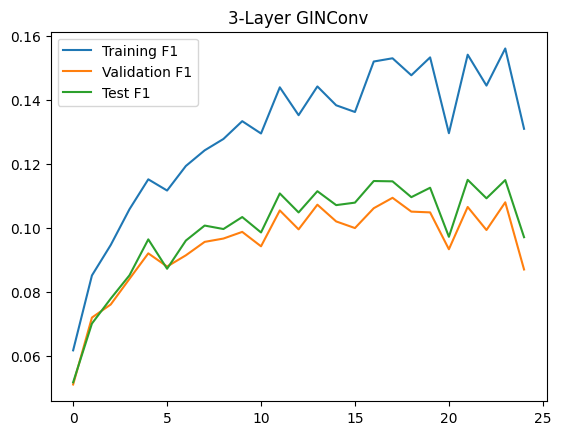

In [ ]:
from matplotlib import pyplot as plt

plt.title("3-Layer GINConv")
plt.plot(train_curve, label="Training F1")
plt.plot(valid_curve, label="Validation F1")
plt.plot(test_curve, label="Test F1")
plt.legend()
plt.show()